# L9 Evaluation part I

Evaluate LLM responses when there is a single "right answer".

How can you track if an LLM model is working? If you find any shortcommings, then how can you continue to improve the quality of your LLM system? 

- Some best practices to evaluate the output of an LLM. 
- How does it feel to build such a system? How is it different from a traditional supervised Machine Learning workflow?

**Process of building an application**
- Tune prompts on handful of examples
    - based on the first few explamples make sure that your prompts work.
- Add additional "tricky" examples opportunistically 
    - Once the model is build, you undergo additional testing on your system
    - You keep these test cases handy to see how newer versions of the model perform on them
- Develop metrices to measure performance in examples
    - Once you have a considerable number of examples that you know could be tricky 
    - You can develop a way to test the performance of the LLM system autumatically, rather than testing each use case individually. 
    - Maybe have "Average Accuracy" to measure the performance of the model. 
- Collect randomly sampled set of examples to tune to (development set/hold-out cross validation set)
    - In case the examples that you have explored are not giving you enough confidence, then you can collect randomly sampled examples to continue to **"tune your prompt"**
- Collect and use a hand-out test set.
    - Only if you need a even higher fidelity estimate of the performance of your system, then you can collect a hold out test set that you don't even look at yourself when you tune he model. 

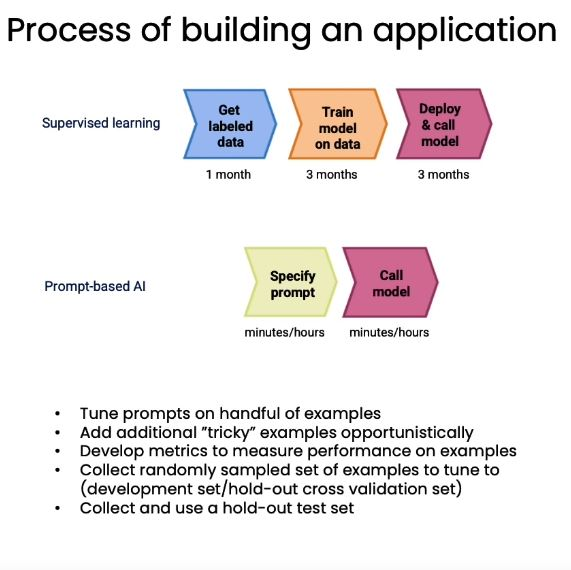

When you are building high stakes applications, where there is risk of bias or an inappropriate output causing harm to someone, they as developers we have the responsibility to collect the test set. We need to rigourously evaluate the performance of the system to make sure that it is doing the right thing.

## Setup
#### Load the API key and relevant Python libaries.
In this course, we've provided some code that loads the OpenAI API key for you.

In [1]:
import os
import openai
import sys
sys.path.append('../..')
import utils
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.environ['OPENAI_API_KEY']

In [3]:
def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=500):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature, 
        max_tokens=max_tokens, 
    )
    return response.choices[0].message["content"]

#### Get the relevant products and categories
Here is the list of products and categories that are in the product catalog.

In [4]:
products_and_category = utils.get_products_and_category()
products_and_category

{'Computers and Laptops': ['TechPro Ultrabook',
  'BlueWave Gaming Laptop',
  'PowerLite Convertible',
  'TechPro Desktop',
  'BlueWave Chromebook'],
 'Smartphones and Accessories': ['SmartX ProPhone',
  'MobiTech PowerCase',
  'SmartX MiniPhone',
  'MobiTech Wireless Charger',
  'SmartX EarBuds'],
 'Televisions and Home Theater Systems': ['CineView 4K TV',
  'SoundMax Home Theater',
  'CineView 8K TV',
  'SoundMax Soundbar',
  'CineView OLED TV'],
 'Gaming Consoles and Accessories': ['GameSphere X',
  'ProGamer Controller',
  'GameSphere Y',
  'ProGamer Racing Wheel',
  'GameSphere VR Headset'],
 'Audio Equipment': ['AudioPhonic Noise-Canceling Headphones',
  'WaveSound Bluetooth Speaker',
  'AudioPhonic True Wireless Earbuds',
  'WaveSound Soundbar',
  'AudioPhonic Turntable'],
 'Cameras and Camcorders': ['FotoSnap DSLR Camera',
  'ActionCam 4K',
  'FotoSnap Mirrorless Camera',
  'ZoomMaster Camcorder',
  'FotoSnap Instant Camera']}

### Find relevant product and category names (version 1)
This could be the version that is running in production.

In [5]:
def find_category_and_product_v1(user_input,products_and_category):

    delimiter = "####"
    system_message = f"""
    You will be provided with customer service queries. \
    The customer service query will be delimited with {delimiter} characters.
    Output a python list of json objects, where each object has the following format:
        'category': <one of Computers and Laptops, Smartphones and Accessories, Televisions and Home Theater Systems, \
    Gaming Consoles and Accessories, Audio Equipment, Cameras and Camcorders>,
    AND
        'products': <a list of products that must be found in the allowed products below>


    Where the categories and products must be found in the customer service query.
    If a product is mentioned, it must be associated with the correct category in the allowed products list below.
    If no products or categories are found, output an empty list.
    

    List out all products that are relevant to the customer service query based on how closely it relates
    to the product name and product category.
    Do not assume, from the name of the product, any features or attributes such as relative quality or price.

    The allowed products are provided in JSON format.
    The keys of each item represent the category.
    The values of each item is a list of products that are within that category.
    Allowed products: {products_and_category}
    

    """
    
    few_shot_user_1 = """I want the most expensive computer."""
    few_shot_assistant_1 = """ 
    [{'category': 'Computers and Laptops', \
'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]
    """
    
    messages =  [  
    {'role':'system', 'content': system_message},    
    {'role':'user', 'content': f"{delimiter}{few_shot_user_1}{delimiter}"},  
    {'role':'assistant', 'content': few_shot_assistant_1 },
    {'role':'user', 'content': f"{delimiter}{user_input}{delimiter}"},  
    ] 
    return get_completion_from_messages(messages)


### Evaluate on some queries

For the version 1 model, we can see that the model is giving satisfactory responses to us in the message #0, #1, and #2, but for #3 it is giving additional text which is not good for our system. You can say that this for this output the model is not giving the expected answer.

In [6]:
customer_msg_0 = f"""Which TV can I buy if I'm on a budget?"""

products_by_category_0 = find_category_and_product_v1(customer_msg_0,
                                                      products_and_category)
print(products_by_category_0)

    [{'category': 'Televisions and Home Theater Systems', 'products': ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']}]


In [7]:
customer_msg_1 = f"""I need a charger for my smartphone"""

products_by_category_1 = find_category_and_product_v1(customer_msg_1,
                                                      products_and_category)
print(products_by_category_1)

    [{'category': 'Smartphones and Accessories', 'products': ['MobiTech PowerCase', 'MobiTech Wireless Charger', 'SmartX EarBuds']}]



In [8]:
customer_msg_2 = f"""
What computers do you have?"""

products_by_category_2 = find_category_and_product_v1(customer_msg_2,
                                                      products_and_category)
products_by_category_2

"    [{'category': 'Computers and Laptops', 'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]"

In [9]:
customer_msg_3 = f"""
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs do you have?"""

products_by_category_3 = find_category_and_product_v1(customer_msg_3,
                                                      products_and_category)
print(products_by_category_3)

    [{'category': 'Smartphones and Accessories', 'products': ['SmartX ProPhone']},
     {'category': 'Cameras and Camcorders', 'products': ['FotoSnap DSLR Camera']},
     {'category': 'Televisions and Home Theater Systems', 'products': ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']}]
     
    Note: The query mentions "smartx pro phone" and "fotosnap camera, the dslr one", so the output includes the relevant categories and products. The query also asks about TVs, so the relevant category is included in the output.


The extra junk makes it more difficult to parse the response of the model. So it is an example where the system fails to deliver the required output.

### Harder test cases
Identify queries found in production, where the model is not working as expected.

You can test the performance of the system with additional test cases where you get feedback from the testers/stakeholders and then present to you some cases where the model is not giving the exoected responses. 

You add these cases to your test set and then further improve the system by **tuning the prompt** to give fewer errors. 

In [10]:
customer_msg_4 = f"""
tell me about the CineView TV, the 8K one, Gamesphere console, the X one.
I'm on a budget, what computers do you have?"""

products_by_category_4 = find_category_and_product_v1(customer_msg_4,
                                                      products_and_category)
print(products_by_category_4)

    [{'category': 'Televisions and Home Theater Systems', 'products': ['CineView 8K TV']},
     {'category': 'Gaming Consoles and Accessories', 'products': ['GameSphere X']},
     {'category': 'Computers and Laptops', 'products': ['BlueWave Chromebook']}]
     
    The CineView TV is a high-end television with 8K resolution, providing an incredibly sharp and detailed picture. It is perfect for those who want the best viewing experience possible.
    
    The GameSphere X is a powerful gaming console that offers a wide range of games and features. It is perfect for gamers who want a high-quality gaming experience.
    
    The BlueWave Chromebook is a budget-friendly laptop that is perfect for those who need a basic computer for everyday use. It is not as powerful as some of the other options, but it is affordable and reliable.


### Modify the prompt to work on the hard test cases (version 2)

In [11]:
def find_category_and_product_v2(user_input,products_and_category):
    """
    Added: Do not output any additional text that is not in JSON format.
    Added a second example (for few-shot prompting) where user asks for 
    the cheapest computer. In both few-shot examples, the shown response 
    is the full list of products in JSON only.
    """
    delimiter = "####"
    system_message = f"""
    You will be provided with customer service queries. \
    The customer service query will be delimited with {delimiter} characters.
    Output a python list of json objects, where each object has the following format:
        'category': <one of Computers and Laptops, Smartphones and Accessories, Televisions and Home Theater Systems, \
    Gaming Consoles and Accessories, Audio Equipment, Cameras and Camcorders>,
    AND
        'products': <a list of products that must be found in the allowed products below>
    Do not output any additional text that is not in JSON format.
    Do not write any explanatory text after outputting the requested JSON.


    Where the categories and products must be found in the customer service query.
    If a product is mentioned, it must be associated with the correct category in the allowed products list below.
    If no products or categories are found, output an empty list.
    

    List out all products that are relevant to the customer service query based on how closely it relates
    to the product name and product category.
    Do not assume, from the name of the product, any features or attributes such as relative quality or price.

    The allowed products are provided in JSON format.
    The keys of each item represent the category.
    The values of each item is a list of products that are within that category.
    Allowed products: {products_and_category}
    

    """
    
    few_shot_user_1 = """I want the most expensive computer. What do you recommend?"""
    few_shot_assistant_1 = """ 
    [{'category': 'Computers and Laptops', \
'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]
    """
    
    few_shot_user_2 = """I want the most cheapest computer. What do you recommend?"""
    few_shot_assistant_2 = """ 
    [{'category': 'Computers and Laptops', \
'products': ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook']}]
    """
    
    messages =  [  
    {'role':'system', 'content': system_message},    
    {'role':'user', 'content': f"{delimiter}{few_shot_user_1}{delimiter}"},  
    {'role':'assistant', 'content': few_shot_assistant_1 },
    {'role':'user', 'content': f"{delimiter}{few_shot_user_2}{delimiter}"},  
    {'role':'assistant', 'content': few_shot_assistant_2 },
    {'role':'user', 'content': f"{delimiter}{user_input}{delimiter}"},  
    ] 
    return get_completion_from_messages(messages)


### Evaluate the modified prompt on the hard tests cases

In [12]:
customer_msg_3 = f"""
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs do you have?"""

products_by_category_3 = find_category_and_product_v2(customer_msg_3,
                                                      products_and_category)
print(products_by_category_3)

    [{'category': 'Smartphones and Accessories', 'products': ['SmartX ProPhone']}, {'category': 'Cameras and Camcorders', 'products': ['FotoSnap DSLR Camera']}, {'category': 'Televisions and Home Theater Systems', 'products': ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']}]



This now gives us the cottect output! 

### Regression testing: verify that the model still works on previous test cases
Check that modifying the model to fix the hard test cases does not negatively affect its performance on previous test cases.

In [13]:
customer_msg_0 = f"""Which TV can I buy if I'm on a budget?"""

products_by_category_0 = find_category_and_product_v2(customer_msg_0,
                                                      products_and_category)
print(products_by_category_0)

    [{'category': 'Televisions and Home Theater Systems', 'products': ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']}]



### Gather development set for automated testing

It can be painful to manually check every single time if the model is giving the correct output. Sometimes there will be extra text, sometimes there will be a few categories missing, etc. 

So, it can be very useful to automate the performance of the development set, instead of manually checking all the possible errors in the response bu running each query for every single iteration of the model. 

The **Test Set** or **Developemnt Set** will look something like this:
- "customer_msg" is the user prompt
- "ideal_answer" is the right answer

In [14]:
msg_ideal_pairs_set = [
    
    # eg 0
    {'customer_msg':"""Which TV can I buy if I'm on a budget?""",
     'ideal_answer':{
        'Televisions and Home Theater Systems':set(
            ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']
        )}
    },

    # eg 1
    {'customer_msg':"""I need a charger for my smartphone""",
     'ideal_answer':{
        'Smartphones and Accessories':set(
            ['MobiTech PowerCase', 'MobiTech Wireless Charger', 'SmartX EarBuds']
        )}
    },
    # eg 2
    {'customer_msg':f"""What computers do you have?""",
     'ideal_answer':{
           'Computers and Laptops':set(
               ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook'
               ])
                }
    },

    # eg 3
    {'customer_msg':f"""tell me about the smartx pro phone and \
    the fotosnap camera, the dslr one.\
    Also, what TVs do you have?""",
     'ideal_answer':{
        'Smartphones and Accessories':set(
            ['SmartX ProPhone']),
        'Cameras and Camcorders':set(
            ['FotoSnap DSLR Camera']),
        'Televisions and Home Theater Systems':set(
            ['CineView 4K TV', 'SoundMax Home Theater','CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV'])
        }
    }, 
    
    # eg 4
    {'customer_msg':"""tell me about the CineView TV, the 8K one, Gamesphere console, the X one.
I'm on a budget, what computers do you have?""",
     'ideal_answer':{
        'Televisions and Home Theater Systems':set(
            ['CineView 8K TV']),
        'Gaming Consoles and Accessories':set(
            ['GameSphere X']),
        'Computers and Laptops':set(
            ['TechPro Ultrabook', 'BlueWave Gaming Laptop', 'PowerLite Convertible', 'TechPro Desktop', 'BlueWave Chromebook'])
        }
    },
    
    # eg 5
    {'customer_msg':f"""What smartphones do you have?""",
     'ideal_answer':{
           'Smartphones and Accessories':set(
               ['SmartX ProPhone', 'MobiTech PowerCase', 'SmartX MiniPhone', 'MobiTech Wireless Charger', 'SmartX EarBuds'
               ])
                    }
    },
    # eg 6
    {'customer_msg':f"""I'm on a budget.  Can you recommend some smartphones to me?""",
     'ideal_answer':{
        'Smartphones and Accessories':set(
            ['SmartX EarBuds', 'SmartX MiniPhone', 'MobiTech PowerCase', 'SmartX ProPhone', 'MobiTech Wireless Charger']
        )}
    },

    # eg 7 # this will output a subset of the ideal answer
    {'customer_msg':f"""What Gaming consoles would be good for my friend who is into racing games?""",
     'ideal_answer':{
        'Gaming Consoles and Accessories':set([
            'GameSphere X',
            'ProGamer Controller',
            'GameSphere Y',
            'ProGamer Racing Wheel',
            'GameSphere VR Headset'
     ])}
    },
    # eg 8
    {'customer_msg':f"""What could be a good present for my videographer friend?""",
     'ideal_answer': {
        'Cameras and Camcorders':set([
        'FotoSnap DSLR Camera', 'ActionCam 4K', 'FotoSnap Mirrorless Camera', 'ZoomMaster Camcorder', 'FotoSnap Instant Camera'
        ])}
    },
    
    # eg 9
    {'customer_msg':f"""I would like a hot tub time machine.""",
     'ideal_answer': []
    }
    
]


### Evaluate test cases by comparing to the ideal answers

In [16]:
import json
def eval_response_with_ideal(response,
                              ideal,
                              debug=False):
    
    if debug:
        print("response")
        print(response)
    
    # json.loads() expects double quotes, not single quotes
    json_like_str = response.replace("'",'"')
    
    # parse into a list of dictionaries
    l_of_d = json.loads(json_like_str)
    
    # special case when response is empty list
    if l_of_d == [] and ideal == []:
        return 1
    
    # otherwise, response is empty 
    # or ideal should be empty, there's a mismatch
    elif l_of_d == [] or ideal == []:
        return 0
    
    correct = 0    
    
    if debug:
        print("l_of_d is")
        print(l_of_d)
    for d in l_of_d:

        cat = d.get('category')
        prod_l = d.get('products')
        if cat and prod_l:
            # convert list to set for comparison
            prod_set = set(prod_l)
            # get ideal set of products
            ideal_cat = ideal.get(cat)
            if ideal_cat:
                prod_set_ideal = set(ideal.get(cat))
            else:
                if debug:
                    print(f"did not find category {cat} in ideal")
                    print(f"ideal: {ideal}")
                continue
                
            if debug:
                print("prod_set\n",prod_set)
                print()
                print("prod_set_ideal\n",prod_set_ideal)

            if prod_set == prod_set_ideal:
                if debug:
                    print("correct")
                correct +=1
            else:
                print("incorrect")
                print(f"prod_set: {prod_set}")
                print(f"prod_set_ideal: {prod_set_ideal}")
                if prod_set <= prod_set_ideal:
                    print("response is a subset of the ideal answer")
                elif prod_set >= prod_set_ideal:
                    print("response is a superset of the ideal answer")

    # count correct over total number of items in list
    pc_correct = correct / len(l_of_d)
        
    return pc_correct

**Example 1:** Correct response

In [20]:
print(f'Customer message: {msg_ideal_pairs_set[0]["customer_msg"]}')
print(f'Ideal answer: {msg_ideal_pairs_set[0]["ideal_answer"]}')


Customer message: What Gaming consoles would be good for my friend who is into racing games?
Ideal answer: {'Gaming Consoles and Accessories': {'GameSphere Y', 'ProGamer Controller', 'GameSphere X', 'GameSphere VR Headset', 'ProGamer Racing Wheel'}}


In [21]:
response = find_category_and_product_v2(msg_ideal_pairs_set[0]["customer_msg"],
                                         products_and_category)
print(f'Resonse: {response}')

eval_response_with_ideal(response,
                              msg_ideal_pairs_set[0]["ideal_answer"])

Resonse:     [{'category': 'Televisions and Home Theater Systems', 'products': ['CineView 4K TV', 'SoundMax Home Theater', 'CineView 8K TV', 'SoundMax Soundbar', 'CineView OLED TV']}]



1.0

**Example 2:** Incorrect response

In [17]:
print(f'Customer message: {msg_ideal_pairs_set[7]["customer_msg"]}')
print(f'Ideal answer: {msg_ideal_pairs_set[7]["ideal_answer"]}')


Customer message: What Gaming consoles would be good for my friend who is into racing games?
Ideal answer: {'Gaming Consoles and Accessories': {'GameSphere Y', 'ProGamer Controller', 'GameSphere X', 'GameSphere VR Headset', 'ProGamer Racing Wheel'}}


In [18]:
response = find_category_and_product_v2(msg_ideal_pairs_set[7]["customer_msg"],
                                         products_and_category)
print(f'Resonse: {response}')

eval_response_with_ideal(response,
                              msg_ideal_pairs_set[7]["ideal_answer"])

Resonse:     [{'category': 'Gaming Consoles and Accessories', 'products': ['ProGamer Controller', 'ProGamer Racing Wheel', 'GameSphere VR Headset']}]
incorrect
prod_set: {'GameSphere VR Headset', 'ProGamer Racing Wheel', 'ProGamer Controller'}
prod_set_ideal: {'GameSphere Y', 'GameSphere VR Headset', 'ProGamer Racing Wheel', 'ProGamer Controller', 'GameSphere X'}
response is a subset of the ideal answer


0.0

### Run evaluation on all test cases and calculate the fraction of cases that are correct

In [22]:
# Note, this will not work if any of the api calls time out
score_accum = 0
for i, pair in enumerate(msg_ideal_pairs_set):
    print(f"example {i}")
    
    customer_msg = pair['customer_msg']
    ideal = pair['ideal_answer']
    
    # print("Customer message",customer_msg)
    # print("ideal:",ideal)
    response = find_category_and_product_v2(customer_msg,
                                                      products_and_category)

    
    # print("products_by_category",products_by_category)
    score = eval_response_with_ideal(response,ideal,debug=False)
    print(f"{i}: {score}")
    score_accum += score
    

n_examples = len(msg_ideal_pairs_set)
fraction_correct = score_accum / n_examples
print(f"Fraction correct out of {n_examples}: {fraction_correct}")

example 0
0: 1.0
example 1
1: 1.0
example 2
2: 1.0
example 3
3: 1.0
example 4
4: 1.0
example 5
5: 1.0
example 6
6: 1.0
example 7
incorrect
prod_set: {'GameSphere VR Headset', 'ProGamer Racing Wheel', 'ProGamer Controller'}
prod_set_ideal: {'GameSphere Y', 'GameSphere VR Headset', 'ProGamer Racing Wheel', 'ProGamer Controller', 'GameSphere X'}
response is a subset of the ideal answer
7: 0.0
example 8
8: 1.0
example 9
9: 1
Fraction correct out of 10: 0.9
